In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
import xgboost
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import seaborn as sns
import operator 
plt.style.use('ggplot')
%matplotlib inline 

Import the data (make sure you update this on a daily basis)

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/05-16-2020.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/05-16-2020.csv')

In [3]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-05-17 02:32:32,34.223334,-82.461707,34,0,0,34,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-05-17 02:32:32,30.295065,-92.414197,192,11,0,181,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-05-17 02:32:32,37.767072,-75.632346,668,9,0,659,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-05-17 02:32:32,43.452658,-116.241552,773,22,0,751,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-05-17 02:32:32,41.330756,-94.471059,4,0,0,4,"Adair, Iowa, US"


In [4]:
latest_data.to_csv('us.csv')

In [64]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,856,868,872,876,880,898,916,933,946,948
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,754,755,755,758,760,761,761,761,761,761
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,43,45,45,45,45,48,48,48,48,50


In [6]:
us_medical_data.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-05-17 02:32:37,32.3182,-86.9023,11674,485,NaN,11189.0,1,238.090139,153494.0,1387.0,4.154531,84000001,USA,3130.495790,11.881103
1,Alaska,US,2020-05-17 02:32:37,61.3707,-152.4044,388,10,344.0,34.0,2,53.038432,33281.0,NaN,2.577320,84000002,USA,4549.412545,NaN
2,American Samoa,US,2020-05-17 02:32:37,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,105.0,NaN,NaN,16,ASM,188.709764,NaN
3,Arizona,US,2020-05-17 02:32:37,33.7298,-111.4312,13666,679,3357.0,9630.0,4,187.752869,146788.0,1683.0,4.968535,84000004,USA,2016.674092,12.315235
4,Arkansas,US,2020-05-17 02:32:37,34.9697,-92.3731,4578,98,3472.0,1008.0,5,151.699713,81644.0,520.0,2.140673,84000005,USA,2705.410954,11.358672


In [7]:
cols = confirmed_df.keys()


### Get outbreak numbers for each day since 1/22/20

In [8]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [9]:
confirmed.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20
0,0,0,0,0,0,0,0,0,0,0,...,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072
1,0,0,0,0,0,0,0,0,0,0,...,856,868,872,876,880,898,916,933,946,948
2,0,0,0,0,0,0,0,0,0,0,...,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201
3,0,0,0,0,0,0,0,0,0,0,...,754,755,755,758,760,761,761,761,761,761
4,0,0,0,0,0,0,0,0,0,0,...,43,45,45,45,45,48,48,48,48,50


Getting daily increases

In [10]:
countries=['china','italy','us','spain','france','germany','uk','russia','brazil']
g = globals()
def init_lists(string):
    ''' initialize the name of lists for each country for 
    confirmed, death, and recovery cases'''
    
    
    for i in countries:
        g['{0}_{1}'.format(i,string)] = []

In [11]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 

#Initializing all the lists
init_lists('cases')
init_lists('deaths')
init_lists('recoveries')

values=['China','Italy','US','Spain','France','Germany','United Kingdom','Russia','Brazil']

for i in dates:
    confirmed_sum = confirmed[i].sum()
    print(type(confirmed_sum))
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculating the mortality and recovery rate
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # getting the confirmed, deaths, and recovered, for each country
    for j in range(len(countries)):
        g['{0}_{1}'.format(countries[j],'cases')].append(confirmed_df[confirmed_df['Country/Region']==values[j]][i].sum())
        g['{0}_{1}'.format(countries[j],'deaths')].append(deaths_df[deaths_df['Country/Region']==values[j]][i].sum())
        g['{0}_{1}'.format(countries[j],'recoveries')].append(recoveries_df[recoveries_df['Country/Region']==values[j]][i].sum())

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'nu

In [12]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

# confirmed cases
world_daily_increase = daily_increase(world_cases)

# deaths
world_daily_death = daily_increase(total_deaths)


# recoveries
world_daily_recovery = daily_increase(total_recovered)


In [13]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
#world_cases = np.array(world_cases).reshape(-1, 1)
#total_deaths = np.array(total_deaths).reshape(-1, 1)
#total_recovered = np.array(total_recovered).reshape(-1, 1)

In [14]:
days_since_1_22

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [15]:
ls=[world_cases, total_deaths, total_recovered, total_active]
df=pd.DataFrame(ls)
df=df.T
df.columns=['confirmed','death','recovered','active']
df

,confirmed,death,recovered,active
0,555,17,28,510
1,654,18,30,606
2,941,26,36,879
3,1434,42,39,1353
4,2118,56,52,2010
...,...,...,...,...
113,4442163,302418,1587893,2551852
114,4542347,307666,1637067,2597614
115,4634068,311781,1693197,2629090
116,4713620,315185,1733963,2664472


In [18]:
df=df.shift(periods=1, freq=None, axis=0)
df=df.fillna(0)
df['label']=total_active
df['days']=days_since_1_22
df.head()

,confirmed,death,recovered,active,label,days
0,0.0,0.0,0.0,0.0,510,0
1,555.0,17.0,28.0,510.0,606,1
2,654.0,18.0,30.0,606.0,879,2
3,941.0,26.0,36.0,879.0,1353,3
4,1434.0,42.0,39.0,1353.0,2010,4


In [19]:
X_train_confirmed, X_test_confirmed = train_test_split(df, test_size=0.20, shuffle=False) 
X_train_confirmed.head()


,confirmed,death,recovered,active,label,days
0,0.0,0.0,0.0,0.0,510,0
1,555.0,17.0,28.0,510.0,606,1
2,654.0,18.0,30.0,606.0,879,2
3,941.0,26.0,36.0,879.0,1353,3
4,1434.0,42.0,39.0,1353.0,2010,4


In [20]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
data_normalized_train = scalar.fit_transform(X_train_confirmed.iloc[:, :-1])
data_normalized_test=scalar.transform(X_test_confirmed.iloc[:, :-1])
train=np.concatenate((X_train_confirmed.iloc[:, -1 :], data_normalized_train), axis = 1)
test=np.concatenate((X_test_confirmed.iloc[:, -1:], data_normalized_test), axis = 1)


In [21]:

X_train=train[:, :-1]
X_test=test[:, :-1]
y_train=train[:, -1:]
y_test=test[:, -1:]


Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [18]:
# # use this to find the optimal parameters for SVR for polynomial kernal
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
degree = [2,3]
svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'degree': degree}

svm = SVR(kernel='poly')
svm_poly = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_iter=30, verbose=1)
svm_poly.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A

/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='poly',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=None,
                   param_distributions={'C': [0.01, 0.1, 1], 'degree': [2, 3],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [20]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_gamma', 'param_epsilon', 'param_degree', 'param_C', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [22]:
df = pd.DataFrame(svm_poly.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_gamma', 'param_epsilon', 'param_degree', 'param_C', 'params',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'mean_train_score', 'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_epsilon,param_degree,param_C,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
2,1.423716,0.752182,0.002751,0.000651,0.01,0.01,3,0.1,"{'gamma': 0.01, 'epsilon': 0.01, 'degree': 3, ...",5.912355e-02,7.855057e-02,1,6.975299e-04,2.143028e-04
17,0.339796,0.126839,0.000476,0.000025,0.1,0.01,2,0.1,"{'gamma': 0.1, 'epsilon': 0.01, 'degree': 2, '...",1.982683e-01,2.720850e-01,2,4.191970e-04,2.055238e-04
3,0.357353,0.104273,0.002886,0.000562,0.1,0.01,2,0.01,"{'gamma': 0.1, 'epsilon': 0.01, 'degree': 2, '...",2.004231e-01,2.747662e-01,3,6.799731e-04,2.383627e-04
18,0.003325,0.001698,0.000380,0.000022,1,0.1,2,1,"{'gamma': 1, 'epsilon': 0.1, 'degree': 2, 'C': 1}",3.187208e-01,4.344356e-01,4,4.022463e-03,1.434699e-04
29,0.004316,0.002355,0.000367,0.000010,0.1,0.1,2,0.1,"{'gamma': 0.1, 'epsilon': 0.1, 'degree': 2, 'C...",3.189151e-01,4.345894e-01,5,4.046604e-03,1.521064e-04
22,0.003110,0.001507,0.000362,0.000008,0.01,0.1,2,1,"{'gamma': 0.01, 'epsilon': 0.1, 'degree': 2, '...",3.193028e-01,4.346846e-01,6,4.183578e-03,2.345285e-04
25,0.010831,0.008710,0.000350,0.000004,0.1,0.1,3,0.1,"{'gamma': 0.1, 'epsilon': 0.1, 'degree': 3, 'C...",4.761405e-01,6.602806e-01,7,3.967242e-03,2.020453e-04
0,0.080437,0.056105,0.003046,0.001122,0.1,0.1,3,0.01,"{'gamma': 0.1, 'epsilon': 0.1, 'degree': 3, 'C...",4.761405e-01,6.602806e-01,7,3.967242e-03,2.020453e-04
21,0.014210,0.010857,0.000359,0.000003,0.01,0.1,3,1,"{'gamma': 0.01, 'epsilon': 0.1, 'degree': 3, '...",4.761623e-01,6.603076e-01,9,3.970207e-03,2.060578e-04
8,0.009820,0.008806,0.000631,0.000108,1,0.1,3,0.1,"{'gamma': 1, 'epsilon': 0.1, 'degree': 3, 'C':...",4.762258e-01,6.602837e-01,10,3.962054e-03,2.225085e-04


In [23]:
svm_poly.best_params_

{'gamma': 0.01, 'epsilon': 0.01, 'degree': 3, 'C': 0.1}

In [42]:
# svm_confirmed = svm_search.best_estimator_
svm_poly = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=0.01, C=0.1,degree=3)
svm_poly.fit(X_train, y_train)
#svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
svm_poly_test_pred = svm_poly.predict(X_test)
print('MAE for SVR polynomial:', mean_absolute_error(svm_poly_test_pred, y_test))
print('MSE for SVR polynomial:',mean_squared_error(svm_poly_test_pred, y_test))
print('R2 value for SVR polynomial:',svm_poly.score(X_test,y_test))

/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE for SVR polynomial: 0.6886793836711926
MSE for SVR polynomial: 0.679318510847204
R2 value for SVR polynomial: -2.2030861091022462


In [22]:
# # use this to find the optimal parameters for SVR for linear
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR(kernel='linear')
svm_linear = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_linear.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.5s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='linear',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [23]:
df = pd.DataFrame(svm_linear.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_shrinking', 'param_gamma', 'param_epsilon', 'param_C', 'params',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'mean_train_score', 'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_shrinking,param_gamma,param_epsilon,param_C,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
14,0.527336,0.346007,0.000679,0.000101,False,1,0.01,1,"{'shrinking': False, 'gamma': 1, 'epsilon': 0....",0.100150,0.137340,1,0.000165,0.000072
19,0.438999,0.358794,0.000504,0.000075,False,0.01,0.01,1,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",0.100150,0.137340,1,0.000165,0.000072
23,0.007527,0.005938,0.000700,0.000077,True,0.01,0.1,1,"{'shrinking': True, 'gamma': 0.01, 'epsilon': ...",0.222561,0.245981,3,0.003892,0.000575
3,0.017483,0.004571,0.000794,0.000077,False,0.01,0.1,1,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",0.222566,0.245978,4,0.003892,0.000575
17,0.019545,0.005460,0.000538,0.000037,False,1,0.1,1,"{'shrinking': False, 'gamma': 1, 'epsilon': 0....",0.222566,0.245978,4,0.003892,0.000575
4,0.049021,0.026166,0.000763,0.000031,False,1,0.01,0.1,"{'shrinking': False, 'gamma': 1, 'epsilon': 0....",0.394859,0.530956,6,0.001473,0.000834
10,0.048649,0.025979,0.000667,0.000035,False,0.01,0.01,0.1,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",0.394859,0.530956,6,0.001473,0.000834
26,0.021239,0.002375,0.000635,0.000056,True,0.01,0.01,0.1,"{'shrinking': True, 'gamma': 0.01, 'epsilon': ...",0.399031,0.536892,8,0.001479,0.000845
9,0.019399,0.003133,0.000701,0.000026,True,1,0.01,0.1,"{'shrinking': True, 'gamma': 1, 'epsilon': 0.0...",0.399031,0.536892,8,0.001479,0.000845
28,0.018702,0.003144,0.000531,0.000020,True,0.1,0.01,0.1,"{'shrinking': True, 'gamma': 0.1, 'epsilon': 0...",0.399031,0.536892,8,0.001479,0.000845


In [24]:
svm_linear.best_params_

{'shrinking': False, 'gamma': 1, 'epsilon': 0.01, 'C': 1}

In [25]:
# svm_confirmed = svm_search.best_estimator_
svm_linear = SVR(shrinking=True, kernel='linear',gamma=0.1, epsilon=0.01, C=1)
svm_linear.fit(X_train, y_train)
#svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
svm_linear_test_pred = svm_linear.predict(X_test)

print('MAE for SVR linear:', mean_absolute_error(svm_linear_test_pred, y_test))
print('MSE for SVR linear:',mean_squared_error(svm_linear_test_pred, y_test))
print('R2 value for SVR linear:',svm_linear.score(X_test,y_test))

/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE for SVR linear: 0.027947955044698325
MSE for SVR linear: 0.0012436813735703211
R2 value for SVR linear: 0.9941358604716009


In [26]:
# # use this to find the optimal parameters for SVR for RBF kernal
c = [0.01, 0.1, 1]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR(kernel='rbf')
svm_rbf = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
svm_rbf.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.1s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [27]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_shrinking', 'param_gamma', 'param_epsilon', 'param_C', 'params',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

In [28]:
df = pd.DataFrame(svm_rbf.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_gamma', 'param_epsilon', 'param_C', 'params',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'mean_train_score', 'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_epsilon,param_C,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
24,0.000541,0.000093,0.000423,0.000044,0.01,0.1,0.01,"{'shrinking': True, 'gamma': 0.01, 'epsilon': ...",1.432943,1.808592,1,0.867749,0.616161
19,0.000647,0.000089,0.000465,0.000065,1,0.1,0.1,"{'shrinking': True, 'gamma': 1, 'epsilon': 0.1...",1.441765,1.791715,2,0.824987,0.587943
17,0.000880,0.000148,0.000683,0.000054,0.1,0.1,0.01,"{'shrinking': True, 'gamma': 0.1, 'epsilon': 0...",1.454747,1.846838,3,1.011093,0.727298
11,0.000926,0.000165,0.000695,0.000059,0.1,0.1,0.01,"{'shrinking': False, 'gamma': 0.1, 'epsilon': ...",1.454747,1.846838,3,1.011093,0.727298
27,0.000886,0.000047,0.000684,0.000037,0.01,0.01,0.01,"{'shrinking': True, 'gamma': 0.01, 'epsilon': ...",1.492612,1.925819,5,0.914986,0.659927
5,0.000977,0.000317,0.000563,0.000131,0.01,0.01,0.01,"{'shrinking': False, 'gamma': 0.01, 'epsilon':...",1.492612,1.925819,5,0.914986,0.659927
29,0.000930,0.000291,0.000620,0.000178,1,0.01,0.1,"{'shrinking': True, 'gamma': 1, 'epsilon': 0.0...",1.497683,1.909798,7,0.872462,0.632709
0,0.000821,0.000213,0.000490,0.000012,0.1,0.1,0.1,"{'shrinking': True, 'gamma': 0.1, 'epsilon': 0...",1.504400,1.699673,8,0.436972,0.305435
28,0.000712,0.000187,0.000560,0.000136,1,0.01,0.01,"{'shrinking': True, 'gamma': 1, 'epsilon': 0.0...",1.510083,1.943730,9,1.126892,0.825263
25,0.000708,0.000134,0.000572,0.000113,1,0.01,0.01,"{'shrinking': False, 'gamma': 1, 'epsilon': 0....",1.510083,1.943730,9,1.126892,0.825263


In [29]:
svm_rbf.best_params_

{'shrinking': True, 'gamma': 0.01, 'epsilon': 0.1, 'C': 0.01}

In [30]:
# svm_confirmed = svm_search.best_estimator_
svm_rbf = SVR(shrinking=False, kernel='linear',gamma=0.01, epsilon=0.1, C=0.01)
svm_rbf.fit(X_train, y_train)
#svm_pred = svm_confirmed.predict(future_forcast)
# check against testing data
svm_rbf_test_pred = svm_rbf.predict(X_test)

print('MAE for SVR rbf:', mean_absolute_error(svm_rbf_test_pred, y_test))
print('MSE for SVR rbf:',mean_squared_error(svm_rbf_test_pred, y_test))
print('R2 value for SVR rbf:',svm_linear.score(X_test,y_test))

MAE for SVR rbf: 0.4330979851452068
MSE for SVR rbf: 0.2356550839057435
R2 value for SVR rbf: 0.9941358604716009


/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Bayesian ridge polynomial regression hyperparameter search

In [31]:
bayesian_poly = PolynomialFeatures(degree=2)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test)

# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [32]:
df = pd.DataFrame(bayesian_search.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_tol', 'param_lambda_2', 'param_lambda_1',
       'param_alpha_2', 'param_alpha_1', 'params', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'mean_train_score',
       'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_lambda_2,param_lambda_1,param_alpha_2,param_alpha_1,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
8,0.001831,0.000592,0.000449,0.000107,0.001,0.001,1e-07,1e-07,1e-07,"{'tol': 0.001, 'lambda_2': 0.001, 'lambda_1': ...",0.029723,0.023046,1,0.000049,0.000021
5,0.004418,0.003098,0.000667,0.000034,0.01,0.001,0.0001,1e-07,1e-05,"{'tol': 0.01, 'lambda_2': 0.001, 'lambda_1': 0...",0.029780,0.023111,2,0.000049,0.000021
4,0.004936,0.002812,0.000820,0.000262,1e-05,0.001,1e-05,1e-06,0.0001,"{'tol': 1e-05, 'lambda_2': 0.001, 'lambda_1': ...",0.029783,0.023051,3,0.000049,0.000021
6,0.004311,0.000836,0.000676,0.000023,1e-06,0.0001,1e-07,1e-07,0.0001,"{'tol': 1e-06, 'lambda_2': 0.0001, 'lambda_1':...",0.030462,0.023577,4,0.000049,0.000021
35,0.003440,0.001241,0.000961,0.000451,1e-05,0.001,1e-06,1e-05,1e-06,"{'tol': 1e-05, 'lambda_2': 0.001, 'lambda_1': ...",0.030468,0.023163,5,0.000049,0.000021
36,0.003069,0.000691,0.000696,0.000056,1e-05,0.0001,1e-07,1e-06,1e-07,"{'tol': 1e-05, 'lambda_2': 0.0001, 'lambda_1':...",0.030531,0.023587,6,0.000049,0.000021
23,0.013097,0.015179,0.000691,0.000044,0.001,0.0001,1e-06,1e-06,1e-07,"{'tol': 0.001, 'lambda_2': 0.0001, 'lambda_1':...",0.030535,0.023591,7,0.000049,0.000021
13,0.003124,0.001857,0.000608,0.000165,1e-05,1e-06,1e-07,1e-07,1e-07,"{'tol': 1e-05, 'lambda_2': 1e-06, 'lambda_1': ...",0.030550,0.023641,8,0.000049,0.000021
15,0.005203,0.003293,0.000624,0.000018,1e-06,1e-07,1e-05,1e-07,1e-06,"{'tol': 1e-06, 'lambda_2': 1e-07, 'lambda_1': ...",0.030550,0.023641,9,0.000049,0.000021
20,0.001955,0.000146,0.000589,0.000033,0.01,0.0001,1e-06,1e-06,0.001,"{'tol': 0.01, 'lambda_2': 0.0001, 'lambda_1': ...",0.030582,0.023647,10,0.000049,0.000021


In [33]:
bayesian_search.best_params_

{'tol': 0.001,
 'lambda_2': 0.001,
 'lambda_1': 1e-07,
 'alpha_2': 1e-07,
 'alpha_1': 1e-07}

In [34]:
bayesian = bayesian_search.best_estimator_
test_bayesian_pred2 = bayesian.predict(bayesian_poly_X_test_confirmed)
print('MAE value for Bayesian Ridge degree 2:', mean_absolute_error(test_bayesian_pred2, y_test))
print('MSE value for Bayesian Ridge degree 2:',mean_squared_error(test_bayesian_pred2, y_test))
print('R2 value for Bayesian Ridge degree 2:',bayesian.score(bayesian_poly_X_test_confirmed,y_test))


MAE value for Bayesian Ridge degree 2: 0.10293690444688154
MSE value for Bayesian Ridge degree 2: 0.02276098745069376
R2 value for Bayesian Ridge degree 2: 0.8926786160414729


In [35]:
bayesian_poly = PolynomialFeatures(degree=3)
bayesian_poly_X_train_confirmed = bayesian_poly.fit_transform(X_train)
bayesian_poly_X_test_confirmed = bayesian_poly.fit_transform(X_test)

# bayesian ridge polynomial regression
tol = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(bayesian_poly_X_train_confirmed, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.3s finished
/home/dell/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           alpha_init=None, compute_score=False,
                                           copy_X=True, fit_intercept=False,
                                           lambda_1=1e-06, lambda_2=1e-06,
                                           lambda_init=None, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='deprecated', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05, 0.0001,
                                                    0.001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                  

In [36]:
df = pd.DataFrame(bayesian_search.cv_results_)
df=df[['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_tol', 'param_lambda_2', 'param_lambda_1',
       'param_alpha_2', 'param_alpha_1', 'params', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'mean_train_score',
       'std_train_score']]
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
df=df.sort_values(by=['mean_test_score'])
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tol,param_lambda_2,param_lambda_1,param_alpha_2,param_alpha_1,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
21,0.003174,0.000375,0.000668,5.440450e-05,1e-06,1e-07,0.001,0.001,1e-06,"{'tol': 1e-06, 'lambda_2': 1e-07, 'lambda_1': ...",592.817019,838.277147,1,0.000039,0.000019
39,0.001359,0.000064,0.000367,2.381111e-05,0.01,1e-07,1e-07,0.001,1e-05,"{'tol': 0.01, 'lambda_2': 1e-07, 'lambda_1': 1...",592.847237,838.319919,2,0.000038,0.000019
31,0.002799,0.000078,0.000635,8.963890e-06,1e-05,1e-07,0.0001,0.001,1e-05,"{'tol': 1e-05, 'lambda_2': 1e-07, 'lambda_1': ...",592.860436,838.338549,3,0.000039,0.000019
14,0.002506,0.000574,0.000581,1.522077e-04,1e-05,1e-06,0.0001,0.001,1e-05,"{'tol': 1e-05, 'lambda_2': 1e-06, 'lambda_1': ...",592.866144,838.346654,4,0.000038,0.000019
0,0.003298,0.000114,0.000546,1.036245e-04,1e-06,1e-06,1e-07,0.001,1e-07,"{'tol': 1e-06, 'lambda_2': 1e-06, 'lambda_1': ...",592.870785,838.353218,5,0.000038,0.000019
27,0.002580,0.000335,0.000664,1.237418e-04,0.01,1e-05,1e-07,0.001,1e-05,"{'tol': 0.01, 'lambda_2': 1e-05, 'lambda_1': 1...",592.915708,838.417075,6,0.000038,0.000019
35,0.004190,0.001532,0.000671,1.589735e-05,1e-06,1e-05,1e-06,0.001,1e-05,"{'tol': 1e-06, 'lambda_2': 1e-05, 'lambda_1': ...",592.933050,838.441574,7,0.000038,0.000019
3,0.002933,0.000079,0.000845,2.122549e-04,1e-05,1e-05,1e-06,0.001,1e-07,"{'tol': 1e-05, 'lambda_2': 1e-05, 'lambda_1': ...",592.933064,838.441595,8,0.000038,0.000019
28,0.002384,0.000133,0.000623,1.576850e-05,0.001,0.0001,0.001,0.001,1e-05,"{'tol': 0.001, 'lambda_2': 0.0001, 'lambda_1':...",593.507602,839.256092,9,0.000038,0.000019
38,0.005658,0.003815,0.000554,2.211566e-04,1e-06,0.0001,1e-06,0.001,0.0001,"{'tol': 1e-06, 'lambda_2': 0.0001, 'lambda_1':...",593.556904,839.325815,10,0.000038,0.000019


In [37]:
bayesian_search.best_params_

{'tol': 1e-06,
 'lambda_2': 1e-07,
 'lambda_1': 0.001,
 'alpha_2': 0.001,
 'alpha_1': 1e-06}

In [38]:
bayesian = bayesian_search.best_estimator_
test_bayesian_pred3 = bayesian.predict(bayesian_poly_X_test_confirmed)
print('MAE value for Bayesian Ridge degree 3:', mean_absolute_error(test_bayesian_pred3, y_test))
print('MSE value for Bayesian Ridge degree 3:',mean_squared_error(test_bayesian_pred3, y_test))
print('R2 value for Bayesian Ridge degree 3:',bayesian.score(bayesian_poly_X_test_confirmed,y_test))


MAE value for Bayesian Ridge degree 3: 1.0182957767406104
MSE value for Bayesian Ridge degree 3: 2.3710079947943434
R2 value for Bayesian Ridge degree 3: -10.179649386006998


In [44]:
# polynomial regression
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X_train, y_train)
test_linear_pred = linear_model.predict(X_test)
print('MAE value for lieanr linear:', mean_absolute_error(test_linear_pred, y_test))
print('MSE value for linear linear:',mean_squared_error(test_linear_pred, y_test))
print('R2 value for linear linear:',linear_model.score(X_test,y_test))


MAE value for lieanr linear: 0.15086160867934376
MSE value for linear linear: 0.03314860790993502
R2 value for linear linear: 0.8436994666905641


In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
rfr = RandomForestRegressor(random_state = 0).fit(X_train, y_train)
test_rf_pred = rfr.predict(X_test)
#linear_pred = linear_model.predict(poly_future_forcast)
print('MAE value for Random forest regressor:', mean_absolute_error(test_rf_pred, y_test))
print('MSE value for Random forest regressor:',mean_squared_error(test_rf_pred, y_test))
print('R2 value for Random forest regressor:',rfr.score(X_test,y_test))


MAE value for Random forest regressor: 0.871008066868585
MSE value for Random forest regressor: 0.970737552897791
R2 value for Random forest regressor: -3.577169503879741


/home/dell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


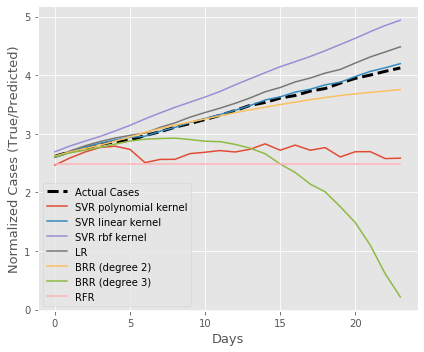

In [116]:
plt.figure(figsize=(6,5))
plt.plot(y_test,color='black',linestyle='--',linewidth=3)
plt.plot(svm_poly_test_pred)
plt.plot(svm_linear_test_pred)
plt.plot(svm_rbf_test_pred)
plt.plot(test_linear_pred)
plt.plot(test_bayesian_pred2)
plt.plot(test_bayesian_pred3)
plt.plot(test_rf_pred)
plt.xlabel('Days', size=13)
plt.ylabel('Normalized Cases (True/Predicted)', size=13)
plt.legend(['Actual Cases','SVR polynomial kernel', 'SVR linear kernel', 'SVR rbf kernel', 
            'LR','BRR (degree 2)',
            'BRR (degree 3)','RFR'],loc='best')
plt.tight_layout()
plt.savefig('predictions.png')

In [56]:
svm_poly_test_pred=svm_poly_test_pred.reshape(24,1)
svm_linear_test_pred=svm_linear_test_pred.reshape(24,1)
svm_rbf_test_pred=svm_rbf_test_pred.reshape(24,1)
test_linear_pred=test_linear_pred.reshape(24,1)
test_bayesian_pred2=test_bayesian_pred2.reshape(24,1)
test_bayesian_pred3=test_bayesian_pred3.reshape(24,1)
test_rf_pred=test_rf_pred.reshape(24,1)

In [57]:
test_rf_pred.shape

(24, 1)

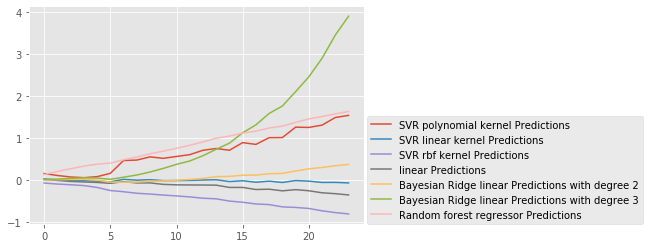

In [59]:
#plt.plot(y_test)
plt.plot(y_test,svm_poly_test_pred)
plt.plot(y_test-svm_linear_test_pred)
plt.plot(y_test-svm_rbf_test_pred)
plt.plot(y_test-test_linear_pred)
plt.plot(y_test-test_bayesian_pred2)
plt.plot(y_test-test_bayesian_pred3)
plt.plot(y_test-test_rf_pred)
plt.legend(['SVR polynomial kernel Predictions', 'SVR linear kernel Predictions', 'SVR rbf kernel Predictions', 
            'linear Predictions','Bayesian Ridge linear Predictions with degree 2',
            'Bayesian Ridge linear Predictions with degree 3','Random forest regressor Predictions'],loc=(1.01,0))


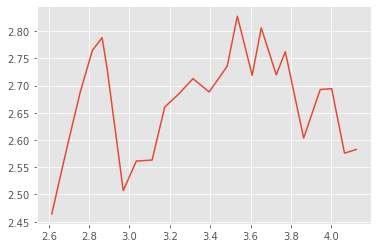

In [60]:
#plt.plot(y_test)
plt.plot(y_test,svm_poly_test_pred)
